In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
from collections import Counter, defaultdict
import copy
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from IPython.display import Image

In [2]:
# will help with filepath construction
cd = !pwd

# Section 1.1

- `men_dict` is the dictionary that contains human annotated similarities for word pairs from the MEN word similarity dataset.

- `simlex_999_dict` is the dictionary that contains human annotated similarities for word pair from the SimLex-999 word similarity dataset.

In [3]:
def gen_VC_dict(filename):
    """
    Generates the features that populate Vc
    """
    V_C_dict = {}
    with open(cd[0]+"/hw1/text_files/"+filename) as document:
        for line in document:
            word = line.strip()
            V_C_dict[word] = 0
    return V_C_dict

def gen_V_dict(vocab_dict, filename):
    """
    Generates the matrix |V| X |Vc| in dictionary form
    """
    V_dict = {}
    with open(cd[0]+"/hw1/text_files/"+filename) as document:
        for line in document:
            V_dict[line.strip()] = copy.deepcopy(vocab_dict) # critical to have deepcopys!

    return V_dict

# Generating Vocabulary dictionaries


The instructions specify  two types of word contexts:

- Section 1: `vocab-wordsim.txt` to populate $V$ and `vocab-25k.txt ` to populate $V_c$

- Section 1.4: `vocab-25k.txt` to populate $V$ and $V_c$


In [4]:
def extract_duplicates(lst):
    """
    helper function for duplicate_indicies
    """
    count = Counter(lst)
    return [k for k in count.keys() if count[k]> 1]

def duplicate_indices(lst):
    """
    Extract the indicies of duplicate elements in a list
    """
    dup, ix = extract_duplicates(lst), defaultdict(list)
    for i, v in enumerate(lst):
        if v in dup: ix[v].append(i)
    return ix

In [5]:
def update_dict(c_dict, mtx_dict, keyword):
    """
    c_dict represents a counter dictionary with the co-occurences around a keyword.
    
    mtx_dict represents the entire word-context matrix in dictionary form (nested dictionarys).
    
    The outer-most keys of mtx_dict correspond to V
    
    The second layer of mtx_dict keys correspond to Vc
    """
    for j in c_dict:
        if j in mtx_dict[keyword]: # we could have certain words that do not exist in Vc
            mtx_dict[keyword][j] += c_dict[j]
        else:
            continue

In [1]:
def process_counts(sen_list, common_set, wind, mtx_dict):
    """
    This function assists with the parsing of sentences in the wikipedia corpus.
    
    The function takes a sentence list, which is a single parsed sentence, from the wiki corpus, as a list.
    
    Common set represents word in the feature space of V that is present in the sentence list.
    
    I iterate through this common set and find the starting index within the parsed sentence list. This serves as the
    starting point to instantiate the window. The window is specified by the wind argument.
    
    This function takes into account that a word that appears in the feature space of V, might appear more than once
    in a parsed sentence. As such, it will calculate the co-occurences in the appropriate window for every instance of
    the word in the parsed sentence.
    
    In order to keep count the co-occuring words, I use the Counter function from the collections library.
    
    This function updates the dictionary INPLACE - there is nothing to be returned.
    
    """
    for word in common_set:

        cent_indicies = duplicate_indices(sen_list)[word]
        if cent_indicies == []:
            cent_idx = sen_list.index(word)
            lower_bound = cent_idx - wind
            
            if lower_bound < 0:
                lower_bound = 0
            
            upper_bound = cent_idx + wind + 1
            
            
            window_list = sen_list[lower_bound:upper_bound]

            window_list.pop(window_list.index(word))

            counter_dict = Counter(window_list)
            update_dict(counter_dict, mtx_dict, word)
        else:
            for cent_idx in cent_indicies:
                lower_bound = cent_idx - wind
            
                if lower_bound < 0:
                    lower_bound = 0
            
                upper_bound = cent_idx + wind + 1
            
                window_list = sen_list[lower_bound:upper_bound]
                
                window_list.pop(window_list.index(word))
                
                counter_dict = Counter(window_list)
                
                update_dict(counter_dict, mtx_dict, word)

In [7]:
def gen_word_context(mtx_dict, window_value):
    """
    Generates the word context matrix, given a matrix dictionary and a window value.
    
    Note: This function alters the inputted mtx_dict IN PLACE, so that it can later be easily turned
    into a pandas dataframe which will represent the word context matrix.
    """
    with open(cd[0]+"/hw1/wiki-1percent.txt") as document:
        count = 0
        V_dim_words = mtx_dict.keys()
        for line in document:
            if count % 100000 == 0:
                print(count, "lines completed so far!")
            line = "<s> " + line + " </s>" #padding a line with <s> and </s>
            cleaned = line.strip()
            sentence_list = cleaned.split()
            common = set(sentence_list).intersection(V_dim_words)
            if common: 
                process_counts(sentence_list, common, window_value, mtx_dict)
                count +=1
            else:
                count += 1
                continue
    return mtx_dict

In [8]:
def extract_human_annotation(filename):
    """
    This function makes a clean dictionary containing the word pairs as keys and the associated human annotated
    similarity scores between them as values.
    """
    d = {}
    with open(cd[0]+"/hw1/text_files/"+filename) as document:
        lst = list(document)
        for i in lst[1:]:
            clean_lst =i.strip().split("\t")
            key=tuple(clean_lst[:2])
            value = float(clean_lst[-1])
            d[key] = value
    return d

def calculate_spearmen(wc_mtx, human_dict):
    """
    Given a word-context matrix (in the form of a pandas dataframe) and a dictionary containing pairs of words as keys
    and their associated human annotated similarity scores as values - this function will calculate the spearmen
    correlation coefficient between the cosine similarity of word pairs in the word-contect matrix and their human
    annotated counterparts.
    """
    wc_cosine_sim = {}
    wc_sim_list = []
    human_sim_list = []
    vocab_list = wc_mtx.index
    
    for pair in human_dict:
        first, second = pair
        if first in vocab_list and second in vocab_list:
            vec_1 = csr_matrix(wc_mtx.loc[first, :].values.reshape(1,-1)) #sparse array
            vec_2 = csr_matrix(wc_mtx.loc[second, :].values.reshape(1,-1)) #sparse array
            wc_cosine_sim[pair] = cosine_similarity(vec_1, vec_2)[0][0]
        else:
            wc_cosine_sim[pair] = 0.0
    
    for pair in human_dict:
        wc_sim_list.append(wc_cosine_sim[pair])
        human_sim_list.append(human_dict[pair])
    
    
    return spearmanr(wc_sim_list, human_sim_list, axis=None).correlation

In [9]:
V_dict_window_3 = gen_V_dict(gen_VC_dict("vocab-25k.txt"), "vocab-wordsim.txt")

word_context_3 = pd.DataFrame(gen_word_context(V_dict_window_3, 3)).T

# these variables below will be useful to reconstruct dataframes later on
ind = word_context_3.index
col_names = word_context_3.columns

print(f"The word-context matrix has dimensions {word_context_3.shape}")

0 lines completed so far!
100000 lines completed so far!
200000 lines completed so far!
300000 lines completed so far!
400000 lines completed so far!
500000 lines completed so far!
600000 lines completed so far!
700000 lines completed so far!
800000 lines completed so far!
900000 lines completed so far!
The word-context matrix has dimensions (1577, 25000)


In [10]:
word_context_3.head()

,!,"""",','a,'an,'art,'brien,'clock,'connell,'connor,...,éireann,émile,ó,über,łódź,α,ᗅᗺᗷᗅ,ὁ,アニメ,곤지
abandoned,0,12,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abdomen,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ability,0,41,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
absence,1,10,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
absorb,0,2,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
men_dict = extract_human_annotation("men.txt")
simlex_999_dict = extract_human_annotation("simlex-999.txt")

In [12]:
# Spearmen correlation with MEN dataset
calculate_spearmen(word_context_3, men_dict)

0.22433852567075044

In [13]:
# Spearmen correlation with SimLex-999 dataset
calculate_spearmen(word_context_3, simlex_999_dict)

0.060167944156962118

In [14]:
# just a fun function I wrote for exploration
# def see_top_rank(mtx_dict, keyword, k):
#     """
#     Given a dictionary representing the entire word-context matrix (nested dictionarys) and a keyword that is present
#     in the dimension of V, and an integer value of k - this function will return the top co-occuring words of the
#     keyword and their respective counts in a list of size k.
#     """
#     return sorted(mtx_dict[keyword].items(), reverse=True, key=lambda x: x[1])[:k]

In [15]:
# # 20 most common words that fall within a 3-window region of the word butterfly
# see_top_rank(V_dict_window_3, "butterfly", 20)

# Section 1.2

Below, we see that spearmen correlation significantly improved when using $C_{pmi}$ with both of the human annoted datasets.

In [9]:
def double_sum(array):
    """
    sum over all rows first and then sum those sums
    """
    return np.sum(np.einsum("ij->i", array))

def gen_joint_probs(array):
    """
    For a given array, generate the joint distribution array
    """
    return array/double_sum(array)

def row_probs(array):
    """
    This function represents p(w) for each row.
    """
    return np.einsum("ij-> i", array)

def col_probs(array):
    """
    This function represents p(context) for each column.
    """
    return np.einsum("ij->j", array)

def gen_PMI(array, smoothing=False, smooth_const=2):
    """
    For a given input array, generate the PMI matrix.
    
    To activate laplace smoothing, set smoothing to True.
    
    Default smoothing set to False. If True, smoothing factor=2
    """
    if smoothing:
        array = array + smooth_const

    context_matrix = gen_joint_probs(array)
    p_w = row_probs(context_matrix)
    p_c = col_probs(context_matrix)
    
    PMI_mtx = context_matrix/p_w[:, np.newaxis]
    PMI_mtx = np.divide(PMI_mtx, p_c)
    PMI_mtx[np.isnan(PMI_mtx)] = 0 
    PMI_mtx[PMI_mtx != 0] = np.log2(PMI_mtx[PMI_mtx!=0])
    PMI_mtx[PMI_mtx < 0] = 0 # remove negative values - PPMI
    
    return PMI_mtx

In [17]:
PMI_3 = gen_PMI(word_context_3.values)
PMI_3_df = pd.DataFrame(data=PMI_3, index=ind, columns=col_names)

In [18]:
# improvement
calculate_spearmen(PMI_3_df,men_dict)

0.53009991996036787

In [19]:
# improvement
calculate_spearmen(PMI_3_df,simlex_999_dict)

0.21155047147102188

## Section 1.3

### Results:

For a $w=1$:

- Word-Context Matrix Spearmen Correlation with MEN: 0.20992265447069547

- Word-Context Spearmen Correlation with SimLex-999: 0.076352221431596479

- PMI Matrix Spearmen Correlation with MEN: 0.46582757219241999

- PMI Matrix Spearmen Correlation with SimLex-999: 0.27174346860787052

For a $w=3$: (See section 1.2 for code)

- Word-Context Matrix Spearmen Correlation with MEN: 0.22433852567075044

- Word-Context Spearmen Correlation with SimLex-999: 0.060167944156962118

- PMI Matrix Spearmen Correlation with MEN: 0.53009991996036787

- PMI Matrix Spearmen Correlation with SimLex-999: 0.21155047147102188

For a $w=6$:

- Word-Context Matrix Spearmen Correlation with MEN: 0.23790636810978752

- Word-Context Spearmen Correlation with SimLex-999: 0.03937517035680782

- PMI Matrix Spearmen Correlation with MEN: 0.52984944584486227

- PMI Matrix Spearmen Correlation with SimLex-999: 0.15988730003494581

### Discussion

The first thing to notice, is that every window level, there is a stronger spearmen correlation when using the PMI matrix over a simple word-context matrix. Intuitively, this makes sense as the PMI matrix represents how closely dependent words are, whereas the word-context matrix is just a simple count.

We also notice that PMI matrix, when compared to the MEN dataset, has the highest correlation coefficient at every window size.

Once again, this is sensible as the MEN dataset is focused on the relatedness of words. As such, the PMI matrix is a measure of relatedness.

It is important to recall that the SimLex-999 dataset is focused on meaning, rather than relatedness - thus, we should not be surpised that we get a spearmen correlation.

We also see that regardless of window level, the spearmen correlation was pretty much constant for the word context matrix when compared to SimLex-999.

The same can be said for the word context matrix when compared to MEN, although there was a slight increase in correlation at $w=6$.

There is a clear downward trend for the PMI matrix when compared with SimLex-999 as window size increases. This might be because an increase in window size, might be confouding the 'meaning' of the centre word.

There was a slight increase in the correlation coefficient between the PMI matrix and the MEN dataset from $w=1$ to $w=3$. From $w=3$ to $w=6$ the correlation remained roughly the same.

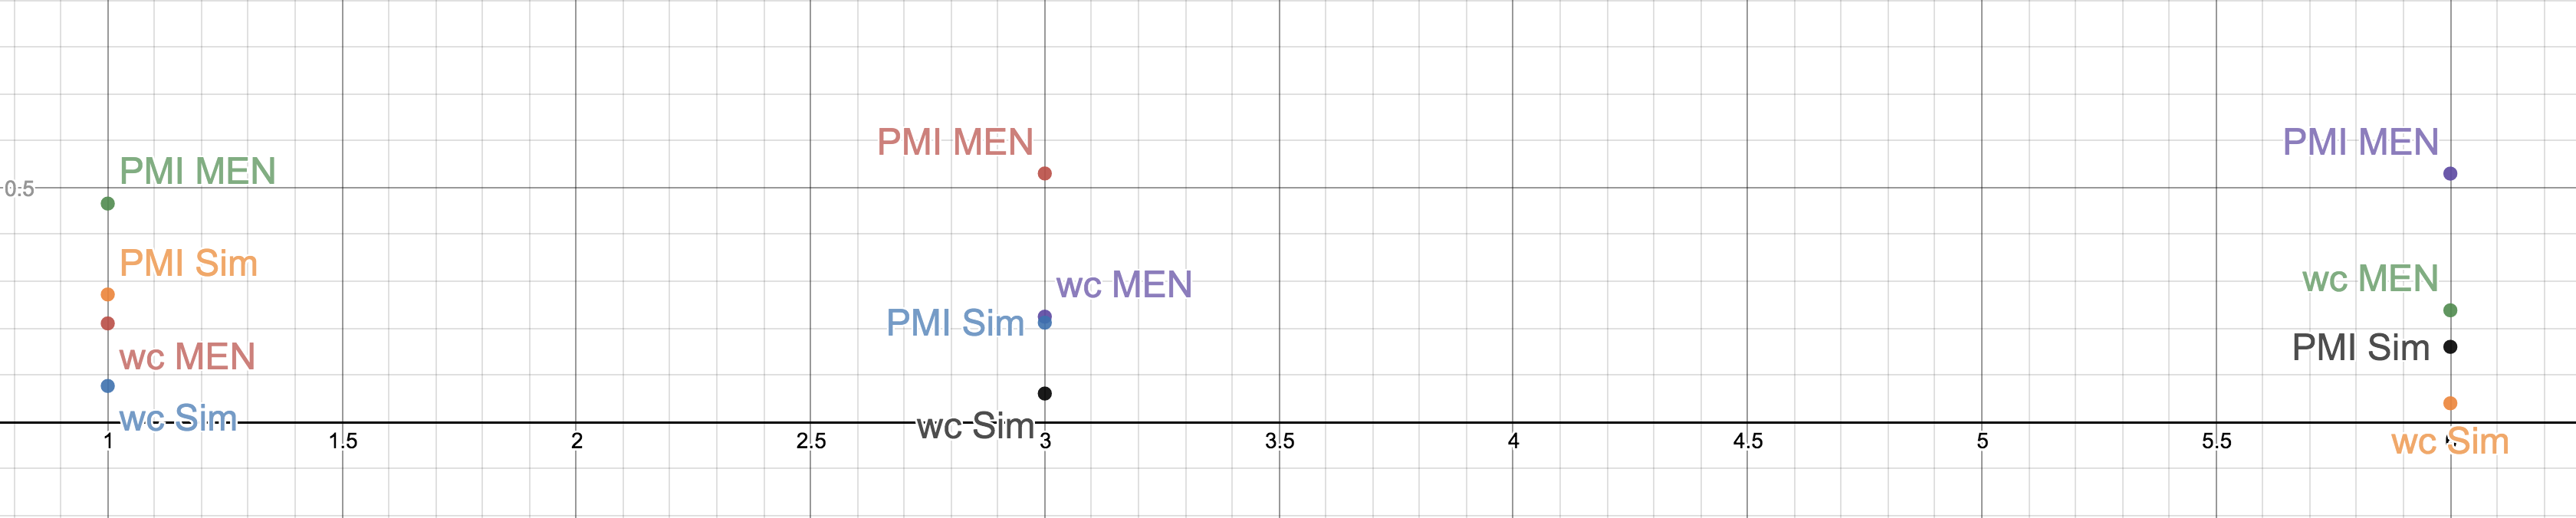

In [20]:
Image("spearmen_plots.png")

In [21]:
V_dict_window_1 = gen_V_dict(gen_VC_dict("vocab-25k.txt"), "vocab-wordsim.txt")
word_context_1 = pd.DataFrame(gen_word_context(V_dict_window_1, 1)).T

PMI_1 = gen_PMI(word_context_1.values)
PMI_1_df = pd.DataFrame(PMI_1, index=ind, columns=col_names)

0 lines completed so far!
100000 lines completed so far!
200000 lines completed so far!
300000 lines completed so far!
400000 lines completed so far!
500000 lines completed so far!
600000 lines completed so far!
700000 lines completed so far!
800000 lines completed so far!
900000 lines completed so far!


In [22]:
calculate_spearmen(word_context_1, men_dict)

0.20992265447069547

In [23]:
calculate_spearmen(word_context_1, simlex_999_dict)

0.076352221431596479

In [24]:
calculate_spearmen(PMI_1_df, men_dict)

0.46582757219241999

In [25]:
calculate_spearmen(PMI_1_df, simlex_999_dict)

0.27174346860787052

In [26]:
V_dict_window_6 = gen_V_dict(gen_VC_dict("vocab-25k.txt"), "vocab-wordsim.txt")
word_context_6 = pd.DataFrame(gen_word_context(V_dict_window_6, 6)).T

PMI_6 = gen_PMI(word_context_6.values)
PMI_6_df = pd.DataFrame(PMI_6, index=ind, columns=col_names)

0 lines completed so far!
100000 lines completed so far!
200000 lines completed so far!
300000 lines completed so far!
400000 lines completed so far!
500000 lines completed so far!
600000 lines completed so far!
700000 lines completed so far!
800000 lines completed so far!
900000 lines completed so far!


In [27]:
calculate_spearmen(word_context_6, men_dict)

0.23790636810978752

In [28]:
calculate_spearmen(word_context_6, simlex_999_dict)

0.03937517035680782

In [29]:
calculate_spearmen(PMI_6_df, men_dict)

0.52984944584486227

In [30]:
calculate_spearmen(PMI_6_df, simlex_999_dict)

0.15988730003494581

# Section 1.4

## Section 1.4.1

In [10]:
def get_neighbors(df, query, k):
    """
    For a given dataframe (PMI), query word and rank (k) - this function will find the k most similar words.
    """
    n_list = []
    V_dim = df.index # only concerned with the |V| dimension.
    
    if query not in V_dim:
        return "This query doesnt not exist in the vocabulary"
    
    query_vector = csr_matrix(df.loc[query, :].values.reshape(1,-1))
    
    for word in V_dim:
        if word == query: #avoid having a cosine similarity of 1 with itself
            continue
        else:
            vector = csr_matrix(df.loc[word, :].values.reshape(1,-1))
            sim_score = cosine_similarity(query_vector, vector)[0][0]
            n_list.append(((query,word),sim_score))
    
    sorted_lst = sorted(n_list, key=lambda x: x[1], reverse=True)
    
    return sorted_lst[:k]

#### Code below (hashed out) was run on AWS servers because of memory constraints. I used sparse matricies for calculations, however, memory usage was taken up from dataframe creation.

#### I used a dataframe as I didnt want to lose track of index and column names. I'm sure there is a better way. I began looking at the following: https://docs.scipy.org/doc/scipy-1.0.0/reference/generated/scipy.sparse.dok_matrix.html#scipy.sparse.dok_matrix

In [32]:
# #creates a very very large dataframe object
# dict_mtx_1 = gen_V_dict(gen_VC_dict("vocab-25k.txt"), "vocab-25k.txt")
# word_context_mtx_1 = pd.DataFrame(gen_word_context(dict_mtx_1, 1)).T

In [33]:
# # # Write to disk in hdf format - conserve memory
# word_context_mtx_1.to_hdf("word_context_mtx_1.hdf", "section_1_4", mode="w")

# word_context_mtx_1 = pd.read_hdf("word_context_mtx_1.hdf", "section_1_4", mode='r+')

In [11]:
word_context_mtx_1 = pd.read_hdf("word_context_mtx_1.hdf", "section_1_4", mode='r+')

In [12]:
ind = word_context_mtx_1.index
col_names = word_context_mtx_1.columns

C_PMI_1 = gen_PMI(word_context_mtx_1.values)
C_PMI_1_df = pd.DataFrame(C_PMI_1, index=ind, columns=col_names)

In [42]:
get_neighbors(C_PMI_1_df, "monster", 10)

[(('monster', 'tyrant'), 0.091455660182717127),
 (('monster', 'dragon'), 0.089465190403988745),
 (('monster', 'creatures'), 0.078561900783129995),
 (('monster', 'jar'), 0.075859226819662812),
 (('monster', 'monsters'), 0.075855460142266184),
 (('monster', 'rhinoceros'), 0.075103853126879699),
 (('monster', 'hornet'), 0.074111599280943019),
 (('monster', 'spaceship'), 0.072446477695767592),
 (('monster', 'gangster'), 0.07241586582074469),
 (('monster', 'invaders'), 0.072328713997566435)]

In [14]:
get_neighbors(C_PMI_1_df, "honda", 10)

[(('honda', 'bmw'), 0.1181313626224296),
 (('honda', 'v8'), 0.095738084630629508),
 (('honda', 'mississauga'), 0.09532303662819186),
 (('honda', 'prototype'), 0.09187104323111675),
 (('honda', 'nissan'), 0.088696861004764399),
 (('honda', 'toyota'), 0.08595337914446452),
 (('honda', 'racing'), 0.085865378361386177),
 (('honda', 'off-road'), 0.085786330623805959),
 (('honda', 'msa'), 0.08490474997386048),
 (('honda', 'helmets'), 0.08450471781591451)]

In [15]:
get_neighbors(C_PMI_1_df, "audi", 10)

[(('audi', 'volkswagen'), 0.12262595711891182),
 (('audi', 'motorway'), 0.11620609243976204),
 (('audi', 'subsidy'), 0.10829278763027003),
 (('audi', 'faber'), 0.10634547086383156),
 (('audi', 'wheels'), 0.1045322491568107),
 (('audi', 'nora'), 0.097442671380306295),
 (('audi', 'mans'), 0.097265786329696416),
 (('audi', 'conglomerate'), 0.093557287242583678),
 (('audi', 'avignon'), 0.088810796881326148),
 (('audi', 'muller'), 0.086806880487171292)]

In [16]:
get_neighbors(C_PMI_1_df, "toyota", 10)

[(('toyota', 'chevrolet'), 0.14086060425942065),
 (('toyota', 'ford'), 0.13005384230602837),
 (('toyota', 'totaling'), 0.11713740884317853),
 (('toyota', 'eine'), 0.11153146584471074),
 (('toyota', 'volvo'), 0.10317780902074943),
 (('toyota', 'speedway'), 0.10285723586028163),
 (('toyota', 'yamaha'), 0.099019328532755746),
 (('toyota', 'touchdowns'), 0.098125980317846001),
 (('toyota', 'seconds'), 0.094329987479142507),
 (('toyota', 'indycar'), 0.094164393302449009)]

In [37]:
# dict_mtx_6 = gen_V_dict(gen_VC_dict("vocab-25k.txt"), "vocab-25k.txt")

# word_context_mtx_6 = pd.DataFrame(gen_word_context(dict_mtx_6, 6)).T

# word_context_mtx_6.to_hdf("word_context_mtx_6.hdf", "section_1_4", mode="w")

In [17]:
word_context_mtx_6 = pd.read_hdf("word_context_mtx_6.hdf", "section_1_4", mode='r+')
ind=word_context_mtx_6.index
col_names = word_context_mtx_6.columns

In [18]:
C_PMI_6 = gen_PMI(word_context_mtx_6.values)
C_PMI_6_df = pd.DataFrame(C_PMI_6, index=ind, columns=col_names)

In [43]:
get_neighbors(C_PMI_6_df, "monster", 10)

[(('monster', '"'), 0.13222354992193822),
 (('monster', 'evil'), 0.12948976534729889),
 (('monster', 'giant'), 0.12553382403562721),
 (('monster', 'godzilla'), 0.12489821311536724),
 (('monster', 'monsters'), 0.12443013222925481),
 (('monster', 'a'), 0.12429136793675384),
 (('monster', 'creature'), 0.12377292811119044),
 (('monster', 'him'), 0.1211353951375634),
 (('monster', 'her'), 0.11769627357133734),
 (('monster', 'man'), 0.11721939577852217)]

In [19]:
get_neighbors(C_PMI_6_df, "honda", 10)

[(('honda', 'toyota'), 0.18735705736794328),
 (('honda', 'nissan'), 0.17456502621369871),
 (('honda', 'racing'), 0.1714196671959351),
 (('honda', 'mitsubishi'), 0.15376205908543525),
 (('honda', 'car'), 0.15174512646967478),
 (('honda', 'speedway'), 0.15146622879214458),
 (('honda', 'indy'), 0.14825607040971986),
 (('honda', 'renault'), 0.14787737884657767),
 (('honda', 'cars'), 0.14775118814864874),
 (('honda', 'engine'), 0.14395110986538126)]

In [20]:
get_neighbors(C_PMI_6_df, "audi", 10)

[(('audi', 'mercedes-benz'), 0.20321859951935228),
 (('audi', 'porsche'), 0.18034912230357231),
 (('audi', 'a4'), 0.14816470451798966),
 (('audi', 'volkswagen'), 0.14814978240331839),
 (('audi', 'bmw'), 0.14777621330321897),
 (('audi', 'mans'), 0.14547008141521098),
 (('audi', 'toyota'), 0.14501446769022699),
 (('audi', 'racing'), 0.14453954645913777),
 (('audi', 'nissan'), 0.14283813375547144),
 (('audi', 'v8'), 0.14283359715224031)]

In [21]:
get_neighbors(C_PMI_6_df, "toyota", 10)

[(('toyota', 'honda'), 0.18735705736794328),
 (('toyota', 'racing'), 0.18654431190871101),
 (('toyota', 'mitsubishi'), 0.18252091686426331),
 (('toyota', 'bmw'), 0.18085521537885096),
 (('toyota', 'nissan'), 0.18009947821667285),
 (('toyota', 'cars'), 0.17817608275005009),
 (('toyota', 'chevrolet'), 0.17559383622842206),
 (('toyota', 'motors'), 0.17552254036088111),
 (('toyota', 'motor'), 0.17315435181605382),
 (('toyota', 'chrysler'), 0.16932458723117708)]

In [22]:
get_neighbors(C_PMI_6_df, "cars", 10)

[(('cars', 'car'), 0.3117000348450657),
 (('cars', 'vehicles'), 0.27991025180561752),
 (('cars', 'engine'), 0.25103832366584333),
 (('cars', 'engines'), 0.22951221360013468),
 (('cars', 'racing'), 0.22131010679920254),
 (('cars', 'vehicle'), 0.2182457806261581),
 (('cars', 'trucks'), 0.20974936541856035),
 (('cars', 'passenger'), 0.20627641870286392),
 (('cars', 'motor'), 0.20539216713121847),
 (('cars', 'chassis'), 0.2033351410693133)]

In [24]:
get_neighbors(C_PMI_6_df, "vin", 10)

[(('vin', 'scully'), 0.095811348305096175),
 (('vin', 'dodgers'), 0.077762487645072612),
 (('vin', 'vaughn'), 0.071803818300485295),
 (('vin', 'rollers'), 0.071128585169162567),
 (('vin', 'vaughan'), 0.068589237170755657),
 (('vin', 'stooges'), 0.067596797799830521),
 (('vin', 'diesel'), 0.065004464436843989),
 (('vin', 'meyer'), 0.064697285448712963),
 (('vin', 'mystery'), 0.063864138701529127),
 (('vin', 'thriller'), 0.062701968845634018)]

## Section 1.4.2

Let us start with the **nouns:**

- Computer
    - with a window of 1, we see only other nounds realted to Computers
    - with a window of 6, we see the verb "using"
    - with a window of 6, we see the adjective "digital"

- Car
    - all neighbors where nouns, regardless of window size

- Cake
    - with a window of 1, we see the verb "drink"
    - with a window of 6, we see the verb "sweet"

**Verbs:**

- Playing
    - A mix of nouns such as played, player, plays
    - Also verbs that are "tightly" related to playing something - such as performing, touring (music perhaps)
    - With a wider window of 6, we see the occurence of more nouns than verbs.

- Installing
    - Fascinating - with a window size of 1, we see lots of verbs
    - With a window size of 6, we see the occurence if lots of nouns related to technology. Ubuntu, Windows, OS etc.

- Commiting
    - Verb heavy neighbors with $w=1$
    - Start to see nounds that can also be viewed as verbs
        - i.e. rape

**Adverbs:**

- Quickly
    - Saw lots of other adverbs with a window size of 1.
    - With a window size of 6, you see lots of "filler" words.

**Adjective:**

- Red
    - Regardless of window size, we get almost identical neighbors. These neighbors are almost all adjectives too.
    
**Preposition:**

- From
    - Leads to the discovery of punctuation, conjunctions, prepositions and adverbs.
    
## Findings

It seems that nounds and verbs "bleed" into each other regardless of context window size.

Adverbs and adjectives seem to stick to their respective groups on average with prepositions bleeding into other prepositions and conjunctions. This makes sense as prepositions are often used with conjunctions!

In [44]:
get_neighbors(C_PMI_1_df, "computer", 10)

[(('computer', 'software'), 0.19158331225588371),
 (('computer', 'computers'), 0.17179603552687497),
 (('computer', 'technology'), 0.15201166482338618),
 (('computer', 'computing'), 0.15010026047024849),
 (('computer', 'systems'), 0.14764793002921708),
 (('computer', 'web'), 0.1436631161968579),
 (('computer', 'graphics'), 0.14214507140692323),
 (('computer', 'hardware'), 0.13613487011328002),
 (('computer', 'pc'), 0.13595725463889355),
 (('computer', 'system'), 0.12911191083741574)]

In [45]:
get_neighbors(C_PMI_6_df, "computer", 10)

[(('computer', 'software'), 0.32197163728708944),
 (('computer', 'systems'), 0.30590227664087544),
 (('computer', 'computers'), 0.29903313627361361),
 (('computer', 'data'), 0.28718083693815427),
 (('computer', 'technology'), 0.27168716306637192),
 (('computer', 'using'), 0.26550439493746975),
 (('computer', 'system'), 0.25649489979168433),
 (('computer', 'applications'), 0.24971989054335017),
 (('computer', 'graphics'), 0.24829611103219976),
 (('computer', 'digital'), 0.24360239663375816)]

In [46]:
get_neighbors(C_PMI_1_df, "car", 10)

[(('car', 'cars'), 0.29346805131261289),
 (('car', 'automobile'), 0.19360189361664168),
 (('car', 'vehicle'), 0.18334741784471026),
 (('car', 'motorcycle'), 0.17661689367713632),
 (('car', 'truck'), 0.17345288529929315),
 (('car', 'train'), 0.15226331852308903),
 (('car', 'aircraft'), 0.15146543849626182),
 (('car', 'auto'), 0.14879560991632759),
 (('car', 'vehicles'), 0.14353616004137984),
 (('car', 'racing'), 0.13647524613206527)]

In [47]:
get_neighbors(C_PMI_6_df, "car", 10)

[(('car', 'cars'), 0.3117000348450657),
 (('car', 'engine'), 0.25712969636754901),
 (('car', 'racing'), 0.25419464033544598),
 (('car', 'vehicle'), 0.24061124053133554),
 (('car', 'motor'), 0.2264079911266457),
 (('car', 'vehicles'), 0.21750545594792037),
 (('car', 'and'), 0.21416817308137567),
 (('car', 'race'), 0.21058779293846855),
 (('car', 'truck'), 0.20940204769421267),
 (('car', 'driver'), 0.20460139280657591)]

In [48]:
get_neighbors(C_PMI_1_df, "cake", 10)

[(('cake', 'pudding'), 0.13441241871343643),
 (('cake', 'cakes'), 0.11720986379994403),
 (('cake', 'cursor'), 0.10422620205475525),
 (('cake', 'noodles'), 0.10234867350422792),
 (('cake', 'drink'), 0.099043742420225955),
 (('cake', 'bread'), 0.095911815571679618),
 (('cake', 'butter'), 0.095588215022358966),
 (('cake', 'dough'), 0.095321005282960586),
 (('cake', 'monobook'), 0.089091168691263933),
 (('cake', 'liquor'), 0.088120426760467538)]

In [49]:
get_neighbors(C_PMI_6_df, "cake", 10)

[(('cake', 'beans'), 0.16339792443812576),
 (('cake', 'bread'), 0.15777617816472483),
 (('cake', 'ingredients'), 0.15122275492494411),
 (('cake', 'dough'), 0.14825929207227784),
 (('cake', 'flour'), 0.14796607083621768),
 (('cake', 'chocolate'), 0.1396134471081158),
 (('cake', 'potato'), 0.13577169738648456),
 (('cake', 'passover'), 0.13574150531213308),
 (('cake', 'meal'), 0.13465885449995346),
 (('cake', 'sweet'), 0.13225260631094146)]

In [50]:
get_neighbors(C_PMI_1_df, "playing", 10)

[(('playing', 'played'), 0.18015275733762862),
 (('playing', 'player'), 0.16825508823211982),
 (('playing', 'plays'), 0.15334288735672838),
 (('playing', 'play'), 0.15166232912244065),
 (('playing', 'players'), 0.13072366038293978),
 (('playing', 'solos'), 0.12986114678766059),
 (('playing', 'soloist'), 0.12729568688787044),
 (('playing', 'touring'), 0.12633627158725727),
 (('playing', 'solo'), 0.12103295237878807),
 (('playing', 'performing'), 0.12102194058352689)]

In [51]:
get_neighbors(C_PMI_6_df, "playing", 10)

[(('playing', 'played'), 0.36360323977951386),
 (('playing', 'football'), 0.29455953035518168),
 (('playing', 'league'), 0.286209290346159),
 (('playing', 'player'), 0.27971356206812126),
 (('playing', 'club'), 0.27400942146140445),
 (('playing', 'team'), 0.27338025803330018),
 (('playing', 'play'), 0.26569940089664784),
 (('playing', 'plays'), 0.2639107935834154),
 (('playing', 'season'), 0.25342350839162142),
 (('playing', ','), 0.24356232415885418)]

In [52]:
get_neighbors(C_PMI_1_df, "installing", 10)

[(('installing', 'install'), 0.12803502366225261),
 (('installing', 're-established'), 0.12421118051562402),
 (('installing', 'inferred'), 0.12098935170930969),
 (('installing', 'sealing'), 0.11103121862274419),
 (('installing', 'supplanted'), 0.1049755109066708),
 (('installing', 'acknowledging'), 0.10280507165242517),
 (('installing', 'deploying'), 0.10266450670791467),
 (('installing', 'drowning'), 0.10045008089696937),
 (('installing', 'ingredient'), 0.099037834799215713),
 (('installing', 'evicted'), 0.097874330632830159)]

In [53]:
get_neighbors(C_PMI_6_df, "installing", 10)

[(('installing', 'ubuntu'), 0.13582106694677423),
 (('installing', 'windows'), 0.12733642344768045),
 (('installing', 'software'), 0.12207626691480512),
 (('installing', 'linux'), 0.11454197089374171),
 (('installing', 'files'), 0.11451719168698232),
 (('installing', 'os'), 0.11362569561133526),
 (('installing', 'disk'), 0.11153163338572859),
 (('installing', 'installed'), 0.11043441924336858),
 (('installing', 'browser'), 0.1092442169778014),
 (('installing', 'firefox'), 0.10836180310360709)]

In [54]:
get_neighbors(C_PMI_1_df, "committing", 10)

[(('committing', 'commit'), 0.25612055249173538),
 (('committing', 'committed'), 0.18446872436463174),
 (('committing', 'disbanding'), 0.11716619876641977),
 (('committing', 'unsolved'), 0.1102553474768015),
 (('committing', 'allegations'), 0.1092644742278874),
 (('committing', 'gunshot'), 0.10661774806582129),
 (('committing', 'atrocities'), 0.099226854951538407),
 (('committing', 'attempting'), 0.095754786180428333),
 (('committing', 'dragging'), 0.095104370987268566),
 (('committing', 'destroying'), 0.094091619833352486)]

In [55]:
get_neighbors(C_PMI_6_df, "committing", 10)

[(('committing', 'suicide'), 0.15851696020497846),
 (('committing', 'crimes'), 0.15033436379872372),
 (('committing', 'committed'), 0.14801791074934137),
 (('committing', 'murder'), 0.13811847151011264),
 (('committing', 'commit'), 0.13300442837964579),
 (('committing', 'criminal'), 0.12808920941499655),
 (('committing', 'convicted'), 0.12791735374217741),
 (('committing', 'rape'), 0.12674766138070678),
 (('committing', 'murders'), 0.1232316767486277),
 (('committing', 'guilty'), 0.12132898265865572)]

In [56]:
get_neighbors(C_PMI_1_df, "quickly", 10)

[(('quickly', 'soon'), 0.26063199526275271),
 (('quickly', 'eventually'), 0.23449414809413593),
 (('quickly', 'rapidly'), 0.21655586258603107),
 (('quickly', 'slowly'), 0.21066917671069785),
 (('quickly', 'finally'), 0.19753536578687289),
 (('quickly', 'then'), 0.18900913647056122),
 (('quickly', 'he'), 0.18716815708164694),
 (('quickly', 'gradually'), 0.18505462524237745),
 (('quickly', 'immediately'), 0.18083694280746793),
 (('quickly', 'never'), 0.17843033686535592)]

In [57]:
get_neighbors(C_PMI_6_df, "quickly", 10)

[(('quickly', 'to'), 0.21927921994418584),
 (('quickly', 'when'), 0.21454110573867108),
 (('quickly', 'they'), 0.21420206807607356),
 (('quickly', 'and'), 0.21295425575565086),
 (('quickly', 'but'), 0.21017895081812732),
 (('quickly', 'him'), 0.20126942345122545),
 (('quickly', 'them'), 0.19559160368578185),
 (('quickly', 'their'), 0.19171498641393017),
 (('quickly', 'into'), 0.19042339385351872),
 (('quickly', 'that'), 0.18709236295883847)]

In [58]:
get_neighbors(C_PMI_1_df, "red", 10)

[(('red', 'white'), 0.29902524375556455),
 (('red', 'blue'), 0.2916533909078986),
 (('red', 'yellow'), 0.27379485563699241),
 (('red', 'black'), 0.26934497710372202),
 (('red', 'green'), 0.23034213756047714),
 (('red', 'pink'), 0.16601980060916902),
 (('red', 'orange'), 0.15808097135051663),
 (('red', 'dark'), 0.15771341409325457),
 (('red', 'golden'), 0.15582216624434639),
 (('red', 'grey'), 0.15505333559981449)]

In [59]:
get_neighbors(C_PMI_6_df, "red", 10)

[(('red', 'white'), 0.33210632385197181),
 (('red', 'blue'), 0.31071934277419122),
 (('red', 'black'), 0.30175053344775254),
 (('red', 'yellow'), 0.30097809385710156),
 (('red', 'green'), 0.27703635003178123),
 (('red', 'with'), 0.27102865568468137),
 (('red', 'and'), 0.26388894507640037),
 (('red', 'dark'), 0.24287044992883897),
 (('red', 'a'), 0.22840034956484101),
 (('red', ','), 0.22291839453985871)]

In [60]:
get_neighbors(C_PMI_1_df, "from", 10)

[(('from', ','), 0.4401781340202699),
 (('from', 'in'), 0.42048719227383763),
 (('from', 'and'), 0.41888347859706065),
 (('from', '('), 0.3512898862885388),
 (('from', '.'), 0.33602933977905519),
 (('from', 'of'), 0.32837310690411015),
 (('from', 'at'), 0.32439646840001463),
 (('from', ')'), 0.3170267670069315),
 (('from', ';'), 0.29742656213306612),
 (('from', 'by'), 0.29348719721077232)]

In [61]:
get_neighbors(C_PMI_6_df, "from", 10)

[(('from', 'and'), 0.36752411913565086),
 (('from', 'in'), 0.35767833711225488),
 (('from', 'between'), 0.34188409013479193),
 (('from', ','), 0.34123214702877508),
 (('from', 'into'), 0.32497614179548079),
 (('from', 'where'), 0.3174623725255224),
 (('from', 'until'), 0.31480319389806943),
 (('from', 'the'), 0.31441311757921031),
 (('from', ';'), 0.31344775195805463),
 (('from', 'after'), 0.31164409055488562)]

# Section 1.4.3

With a window size of 1, you see some synonyms (in the case of light), however, when you expand the wiondow size, you find other words, that sometimes represent the antonym for a word i.e. dark (in the case of light).

For "axes", a small window size leads to the discovery of "non-technical" languages, however, a larger window size begins to delve into fields like mathematics (i.e. orthogonal) and even BlackSmithing (Grinder).

Bank is an interesting case - regardless of window size, you see related words to financial institutions.

As interesting caveat to this is the window size of 6 revealed the word "river". This may suggest that in literature, when using the word bank, we are usually referring to an institution rather than a body of water/geography.

In [62]:
get_neighbors(C_PMI_1_df, "light", 10)

[(('light', 'heavy'), 0.15712065639200096),
 (('light', 'lights'), 0.14670236355917246),
 (('light', 'or'), 0.12911897073760506),
 (('light', 'bright'), 0.12681327381436061),
 (('light', 'radiation'), 0.11845679156278663),
 (('light', 'dark'), 0.11741780111191008),
 (('light', 'pale'), 0.11661646218075611),
 (('light', 'and'), 0.11502720797940848),
 (('light', 'fire'), 0.11141480683611131),
 (('light', 'water'), 0.10777138734886027)]

In [63]:
get_neighbors(C_PMI_6_df, "light", 10)

[(('light', 'with'), 0.25382115330912913),
 (('light', 'and'), 0.25076588817937678),
 (('light', 'are'), 0.23334689919129759),
 (('light', 'or'), 0.23277530627107534),
 (('light', 'can'), 0.23225890964804377),
 (('light', 'using'), 0.22607359885552056),
 (('light', 'which'), 0.22166241599480938),
 (('light', 'used'), 0.22091591799267077),
 (('light', 'surface'), 0.21795530726119669),
 (('light', 'dark'), 0.2159683451874887)]

In [64]:
get_neighbors(C_PMI_1_df, "axes", 10)

[(('axes', 'facets'), 0.13126347442003178),
 (('axes', 'paths'), 0.12999167930213973),
 (('axes', 'phases'), 0.12168224878337497),
 (('axes', 'tributaries'), 0.11833454715193988),
 (('axes', 'concurrency'), 0.11742377112890173),
 (('axes', 'atypical'), 0.11134954099952876),
 (('axes', 'engravings'), 0.1100985137723231),
 (('axes', 'b-sides'), 0.10690469344577602),
 (('axes', 'antagonists'), 0.10141611526011238),
 (('axes', 'strands'), 0.10098877308859093)]

In [65]:
get_neighbors(C_PMI_6_df, "axes", 10)

[(('axes', 'grind'), 0.12378522612758316),
 (('axes', 'angles'), 0.11062917507249988),
 (('axes', 'vectors'), 0.10991373109628774),
 (('axes', 'axe'), 0.10070455337668442),
 (('axes', 'flint'), 0.098938538192759912),
 (('axes', 'orthogonal'), 0.096687578391402143),
 (('axes', 'intersect'), 0.095940096239885891),
 (('axes', 'coordinate'), 0.094191019069364376),
 (('axes', 'directions'), 0.094113020971773056),
 (('axes', 'parallel'), 0.09388848108175106)]

In [66]:
get_neighbors(C_PMI_1_df, "bank", 10)

[(('bank', 'banks'), 0.17390338957881754),
 (('bank', 'insurance'), 0.11673903325212352),
 (('bank', 'company'), 0.11326556861514793),
 (('bank', 'banking'), 0.10857180585455732),
 (('bank', 'corporation'), 0.10035122699776007),
 (('bank', 'government'), 0.095022918425753833),
 (('bank', 'the'), 0.094796028461920978),
 (('bank', 'railway'), 0.092711975646443123),
 (('bank', 'and'), 0.092438577645217124),
 (('bank', 'companies'), 0.092175975075866931)]

In [67]:
get_neighbors(C_PMI_6_df, "bank", 10)

[(('bank', 'banks'), 0.21776980303341956),
 (('bank', 'company'), 0.20627550059291666),
 (('bank', 'banking'), 0.19944949228358338),
 (('bank', 'river'), 0.19526166575175796),
 (('bank', 'corporation'), 0.19462467118186419),
 (('bank', 'west'), 0.18815889759109089),
 (('bank', 'investment'), 0.18770044741597272),
 (('bank', ','), 0.18750190572482214),
 (('bank', 'and'), 0.18466153301403773),
 (('bank', 'located'), 0.18343505881497782)]

# Dimensionality Reducation

In [11]:
dict_mtx_dim = gen_V_dict(gen_VC_dict("vocab-3k.txt"), "vocab-25k+wordsim.txt")

In [12]:
wc_mtx_dim_3 = pd.DataFrame(gen_word_context(dict_mtx_dim, 3)).T

ind = wc_mtx_dim_3.index
col_names = wc_mtx_dim_3.columns

C_PMI_dim = gen_PMI(wc_mtx_dim_3.values)
C_PMI_dim_df = pd.DataFrame(C_PMI_dim, index=ind, columns=col_names)

0 lines completed so far!
100000 lines completed so far!
200000 lines completed so far!
300000 lines completed so far!
400000 lines completed so far!
500000 lines completed so far!
600000 lines completed so far!
700000 lines completed so far!
800000 lines completed so far!
900000 lines completed so far!


### Baseline with just word counts

In [38]:
calculate_spearmen(wc_mtx_dim_3, men_dict)

0.23223229343659896

In [39]:
calculate_spearmen(wc_mtx_dim_3, simlex_999_dict)

0.064130284534525794

### Baseline with just PMI

We see improvements from just using word count - this is to be expected!

In [40]:
calculate_spearmen(C_PMI_dim_df, men_dict)

0.41665330786724125

In [41]:
calculate_spearmen(C_PMI_dim_df, simlex_999_dict)

0.16698551501216272

In [32]:
sparse_PMI = csr_matrix(C_PMI_dim)
ind = list(ind)
k_10_svd = TruncatedSVD(n_components=10).fit_transform(sparse_PMI)
k_50_svd = TruncatedSVD(n_components=50).fit_transform(sparse_PMI)
k_100_svd = TruncatedSVD(n_components=100).fit_transform(sparse_PMI)
k_500_svd = TruncatedSVD(n_components=500).fit_transform(sparse_PMI)
k_1000_svd = TruncatedSVD(n_components=1000).fit_transform(sparse_PMI)

In [36]:
def spearmenr_dim(svd_mtx, human_dict, index_mapping):
    """
    Given a truncated SVD matrix, a dictionary containing pairs of words as keys
    and their associated human annotated similarity scores as values, and an index mapping
    of words to row values from the original vocabulary - this function will calculate the spearmen
    correlation coefficient between the cosine similarity of word pairs in the SVD matrix and their human
    annotated counterparts.
    """
    svd_cosine_sim = {}
    svd_sim_list = []
    human_sim_list = []
    
    for pair in human_dict:
        first, second = pair
        if first in index_mapping and second in index_mapping:
            first_index = index_mapping.index(first)
            second_index = index_mapping.index(second)
            vec_1 = csr_matrix(svd_mtx[first_index, :].reshape(1,-1)) #sparse array
            vec_2 = csr_matrix(svd_mtx[second_index, :].reshape(1,-1)) #sparse array
            svd_cosine_sim[pair] = cosine_similarity(vec_1, vec_2)[0][0]
        else:
            svd_cosine_sim[pair] = 0.0
    
    for pair in human_dict:
        svd_sim_list.append(svd_cosine_sim[pair])
        human_sim_list.append(human_dict[pair])
    
    
    return spearmanr(svd_sim_list, human_sim_list, axis=None).correlation

In [37]:
results = [(spearmenr_dim(k_10_svd, men_dict, ind), spearmenr_dim(k_10_svd, simlex_999_dict, ind)),
          (spearmenr_dim(k_50_svd, men_dict, ind), spearmenr_dim(k_50_svd, simlex_999_dict, ind)),
          (spearmenr_dim(k_100_svd, men_dict, ind), spearmenr_dim(k_100_svd, simlex_999_dict, ind)),
          (spearmenr_dim(k_500_svd, men_dict, ind), spearmenr_dim(k_500_svd, simlex_999_dict, ind)),
          (spearmenr_dim(k_1000_svd, men_dict, ind), spearmenr_dim(k_1000_svd, simlex_999_dict, ind))]
index = [10,50,100,500,1000]
columns = ["MEN-DataSet", "SimLex-999"]
pd.DataFrame(results, index=index, columns=columns)

,MEN-DataSet,SimLex-999
10,0.367336,0.169385
50,0.484964,0.215532
100,0.496165,0.221497
500,0.450595,0.190780
1000,0.428874,0.180366


We see that for dimensions of $k > 10$, we see higher similarity scores for both datasets! The peak of these scores is reached at $k=100$

As stated in section 16.1.2 of SLP: SVD performs better at tasks of word similarity than raw PPMI.